In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data\cost_function\dataset_0.csv")

2
0.0     Axes(0.125,0.11;0.62x0.77)
1.0     Axes(0.125,0.11;0.62x0.77)
2.0     Axes(0.125,0.11;0.62x0.77)
3.0     Axes(0.125,0.11;0.62x0.77)
4.0     Axes(0.125,0.11;0.62x0.77)
5.0     Axes(0.125,0.11;0.62x0.77)
6.0     Axes(0.125,0.11;0.62x0.77)
7.0     Axes(0.125,0.11;0.62x0.77)
8.0     Axes(0.125,0.11;0.62x0.77)
9.0     Axes(0.125,0.11;0.62x0.77)
10.0    Axes(0.125,0.11;0.62x0.77)
11.0    Axes(0.125,0.11;0.62x0.77)
dtype: object

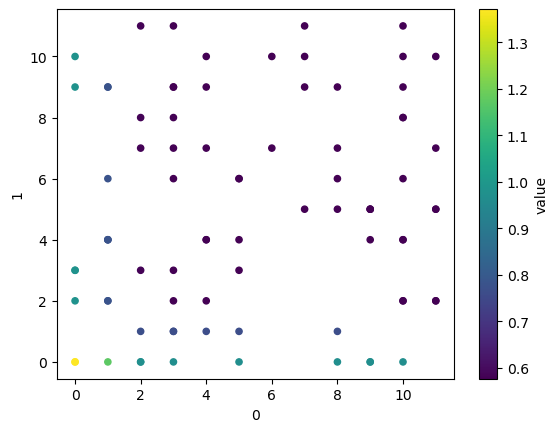

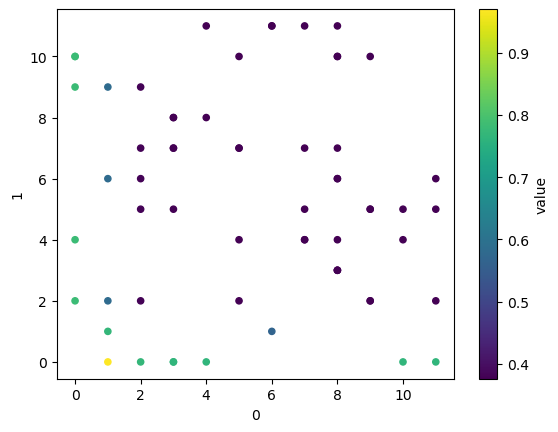

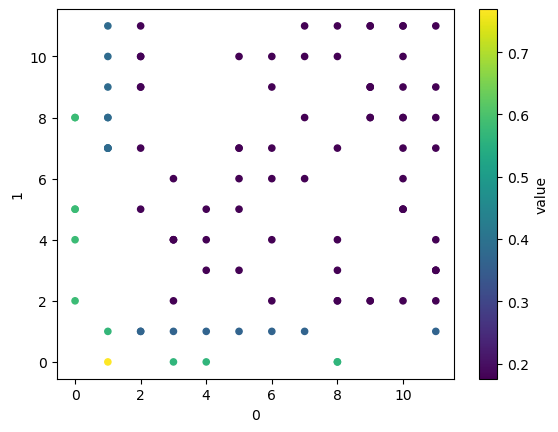

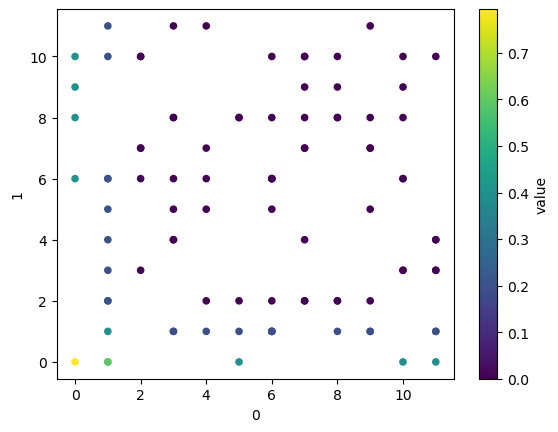

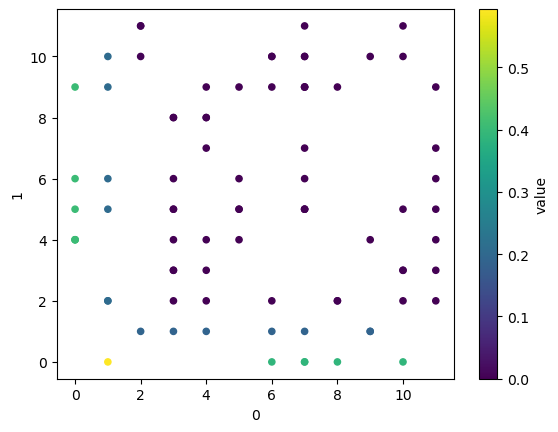

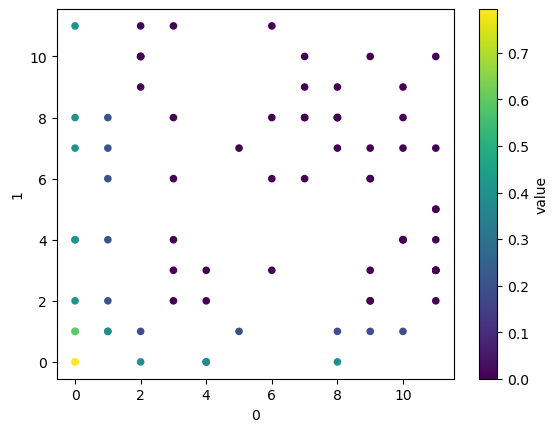

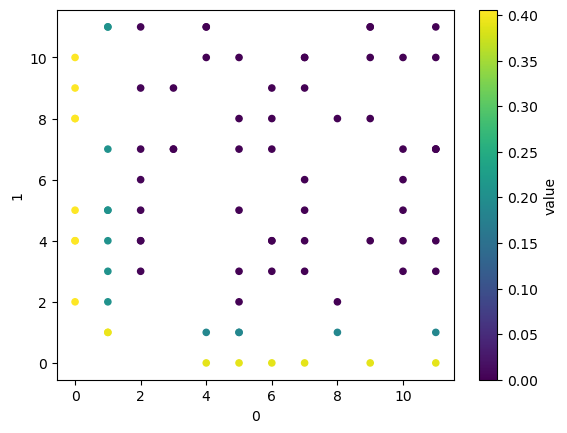

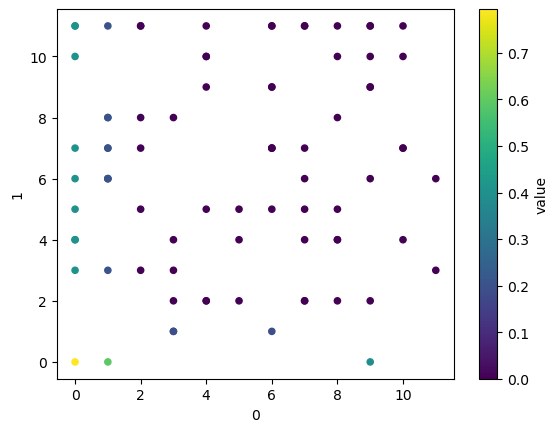

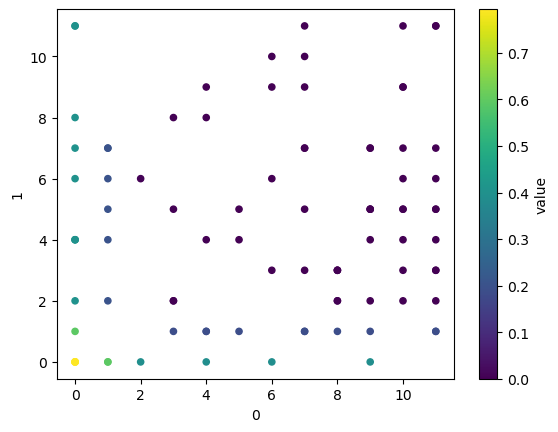

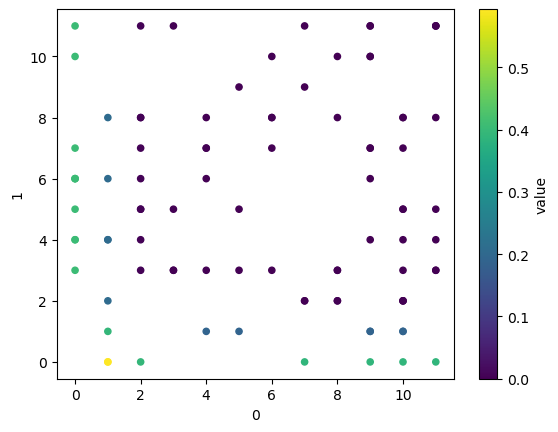

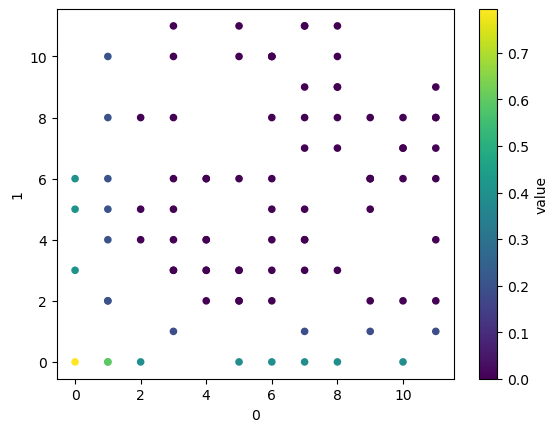

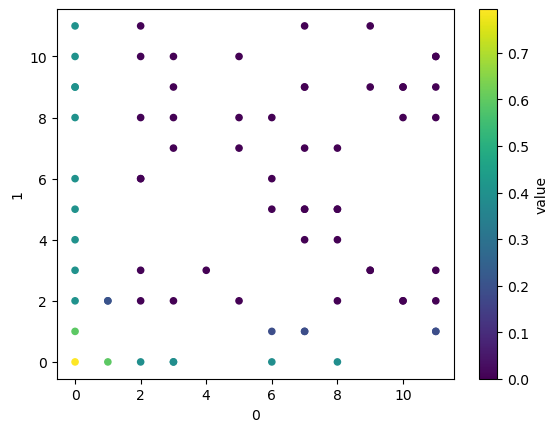

In [4]:
df.groupby("2").plot(kind='scatter',x='0',y='1',c='value')

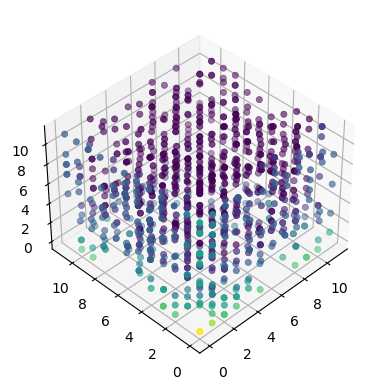

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df["0"], df["1"],df["2"], c = df["value"], cmap='viridis', linewidth=0.5)
# Set zoom and angle view
ax.view_init(40, -135, 0)
ax.set_box_aspect(None, zoom=0.9)

<Axes: xlabel='0', ylabel='value'>

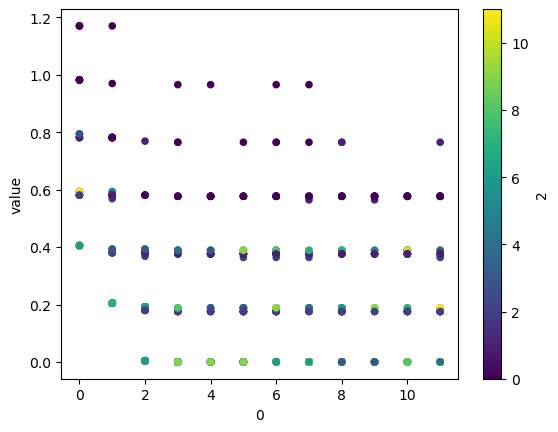

In [34]:
df.plot(kind='scatter',x='0',y='value', c='2')